In [32]:
import pandas as pd
import numpy as np
import os

from sklearn.pipeline import Pipeline
import shap
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_curve, \
roc_auc_score, precision_recall_curve, confusion_matrix, r2_score, mean_absolute_error, \
mean_squared_error
import pandas_profiling as pp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

In [33]:
from keras.models import load_model
import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Dense, Dropout, Embedding, Reshape
from keras.backend import clear_session
from keras.optimizers import Adam
from keras import backend as K
from keras.models import Model
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

Read the data

In [34]:
df_train = pd.read_csv('../data/MEPS_data_preprocessed_train.csv')
df_test = pd.read_csv('../data/MEPS_data_preprocessed_test.csv')

In [35]:
df_all = pd.concat([df_train, df_test]).reset_index(drop=True)

In [36]:
df_all

,PANEL,REGION,AGE31X,GENDER,RACE3,MARRY31X,EDRECODE,FTSTU31X,ACTDTY31,HONRDC31,...,PCS42,MCS42,K6SUM42,PHQ242,EMPST31,POVCAT15,INSCOV15,INCOME_M,HEALTHEXP,PERSONWT
0,20,1,49,1.0,0.0,1,16,-1,2,2,...,51.29,59.04,1,0,1,3,1,8400.0,1462,6156.790949
1,19,3,43,1.0,0.0,4,14,-1,2,2,...,19.36,31.90,14,2,4,1,2,0.0,14121,23114.487222
2,19,1,75,1.0,0.0,1,13,-1,4,2,...,25.23,45.46,6,2,4,4,1,22619.0,58507,17966.491961
3,20,1,26,0.0,1.0,5,13,-1,2,2,...,49.13,63.97,4,0,1,3,1,20000.0,0,4175.967957
4,20,3,43,1.0,0.0,9,14,-1,2,2,...,-1.00,-1.00,-1,-1,1,4,1,58000.0,53936,8877.535274
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18345,19,1,76,1.0,0.0,2,14,-1,4,2,...,53.75,59.70,0,0,4,5,1,53703.0,12112,11022.754377
18346,19,4,34,1.0,0.0,1,16,-1,2,2,...,58.45,41.13,6,2,1,5,1,56005.0,2261,22967.944645
18347,19,2,36,0.0,1.0,5,14,-1,2,2,...,49.93,55.96,1,1,1,5,1,129000.0,1378,11997.302311
18348,20,2,4,1.0,0.0,6,-1,-1,3,3,...,-1.00,-1.00,-1,-1,-1,4,2,0.0,501,11756.273592


In [37]:
df_raw = df_all.copy()

Let's have a closer look at the predicted variable (HEALTHEXP)

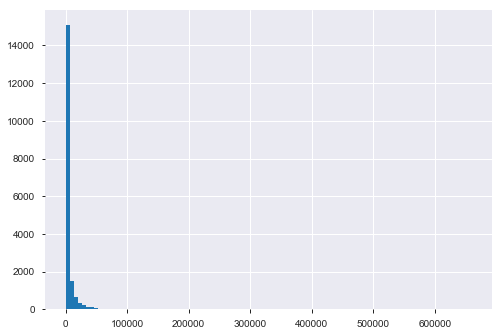

In [38]:
df_all['HEALTHEXP'].hist(bins=100)

In [39]:
df_all['HEALTHEXP'].describe(percentiles=np.linspace(0,1,21))

count     18350.000000
mean       5184.511608
std       15126.748532
min           0.000000
0%            0.000000
5%            0.000000
10%           0.000000
15%          20.350000
20%         114.000000
25%         198.000000
30%         302.000000
35%         431.000000
40%         585.000000
45%         779.000000
50%        1034.000000
55%        1339.000000
60%        1784.800000
65%        2343.850000
70%        3099.000000
75%        4219.500000
80%        5619.800000
85%        8137.000000
90%       12591.100000
95%       23417.000000
100%     659952.000000
max      659952.000000
Name: HEALTHEXP, dtype: float64

In [40]:
health_exp = df_all['HEALTHEXP'].values

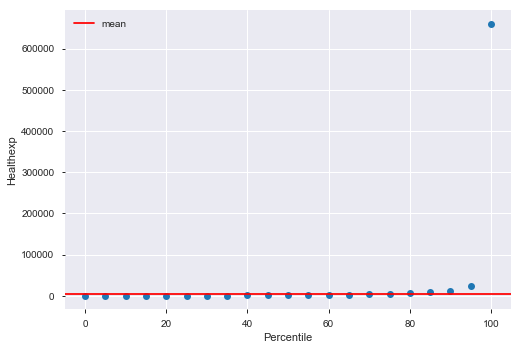

In [41]:
plt.plot(np.linspace(0,100,21), np.percentile(health_exp, np.linspace(0,100,21)),'o');
plt.axhline(y=np.mean(health_exp), color='red', label = 'mean')
plt.xlabel('Percentile');
plt.ylabel('Healthexp');
plt.legend();

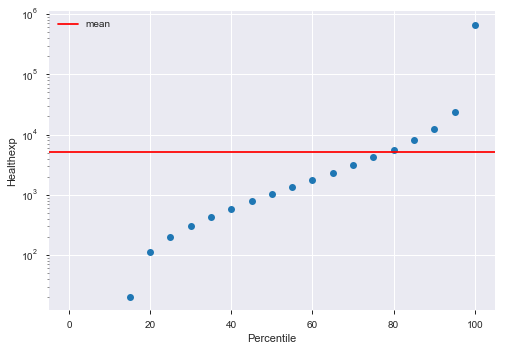

In [42]:
plt.plot(np.linspace(0,100,21), np.percentile(health_exp, np.linspace(0,100,21)),'o');
plt.axhline(y=np.mean(health_exp), color='red', label = 'mean')
plt.xlabel('Percentile');
plt.ylabel('Healthexp');
plt.yscale('log')
plt.legend();

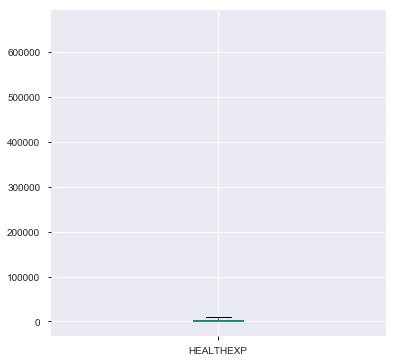

In [43]:
plt.figure(figsize=(6,6))
df_all[['HEALTHEXP']].boxplot();

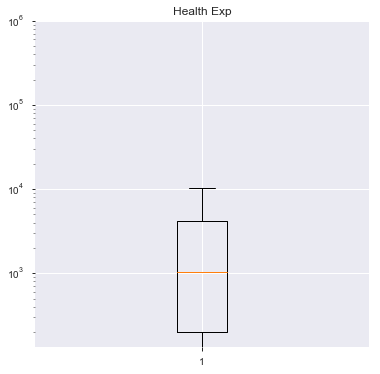

In [44]:
plt.figure(figsize=(6,6))
plt.boxplot(df_all['HEALTHEXP']);
plt.title('Health Exp')
plt.yscale('log')

Notes on predicted variable:
* 14.3 % of observations are equal to 0.
* The distribution is positevely skewed with many high-value outliers (very high treatment costs).
* About 80 % of observations are below the mean. Std is three times higher than  the mean.

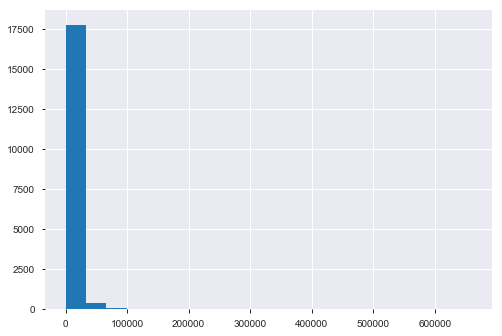

In [45]:
df_all['HEALTHEXP'].hist(bins=20)

Log_3 transformation of health_exp

In [46]:
all_dfs = [df_all, df_train, df_test]

In [47]:
for df in all_dfs:
    log = np.log(df['HEALTHEXP'])
    log[log<0] = 0
    log = log/np.log(3)
    df['HEALTHEXP'] = log

divide by zero encountered in log


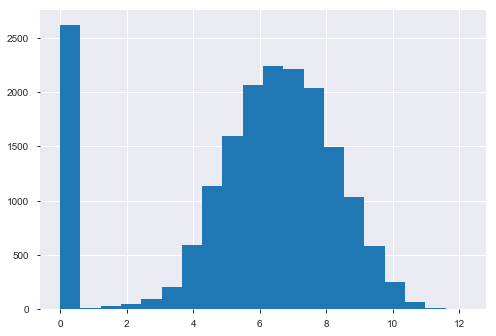

In [48]:
df_all['HEALTHEXP'].hist(bins=20)

Prepare features

In [49]:
# Drop panel number (not meant to be predictive) and sample weights
for df in all_dfs:
    df.drop(columns = ['PANEL', 'PERSONWT'], inplace=True)


In [50]:
df_all.columns

Index(['REGION', 'AGE31X', 'GENDER', 'RACE3', 'MARRY31X', 'EDRECODE',
       'FTSTU31X', 'ACTDTY31', 'HONRDC31', 'RTHLTH31', 'MNHLTH31', 'HIBPDX',
       'CHDDX', 'ANGIDX', 'MIDX', 'OHRTDX', 'STRKDX', 'EMPHDX', 'CHBRON31',
       'CHOLDX', 'CANCERDX', 'DIABDX', 'JTPAIN31', 'ARTHDX', 'ARTHTYPE',
       'ASTHDX', 'ADHDADDX', 'PREGNT31', 'WLKLIM31', 'ACTLIM31', 'SOCLIM31',
       'COGLIM31', 'DFHEAR42', 'DFSEE42', 'ADSMOK42', 'PCS42', 'MCS42',
       'K6SUM42', 'PHQ242', 'EMPST31', 'POVCAT15', 'INSCOV15', 'INCOME_M',
       'HEALTHEXP'],
      dtype='object')

In [51]:
y = df_all.pop('HEALTHEXP')
y_train = df_train.pop('HEALTHEXP')
y_test = df_test.pop('HEALTHEXP')

One-hot encoding for all the categorical features 

In [52]:
categorical_features = ['REGION','MARRY31X','EDRECODE','FTSTU31X','ACTDTY31','HONRDC31',
            'RTHLTH31','MNHLTH31','HIBPDX','CHDDX','ANGIDX','MIDX','OHRTDX','STRKDX',
            'EMPHDX','CHBRON31','CHOLDX','CANCERDX','DIABDX','JTPAIN31','ARTHDX',
            'ARTHTYPE','ASTHDX','ADHDADDX','PREGNT31','WLKLIM31','ACTLIM31','SOCLIM31',
            'COGLIM31','DFHEAR42','DFSEE42','ADSMOK42','PHQ242','EMPST31','POVCAT15','INSCOV15','RACE3','GENDER']

numerical_features= [feat for feat in df.columns if feat not in categorical_features]

In [53]:
numerical_transformer = Pipeline(
    steps=[
        ('scaler', StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


In [54]:
X_train = preprocessor.fit_transform(df_train)
X_test = preprocessor.transform(df_test)

In [55]:
def create_model(optimizer=Adam(4e-5)):
    model = Sequential([
        Dense(128, activation=tf.nn.relu, input_shape=[np.shape(X_train)[1]]),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)
      ])

    model.compile(loss='mse',
                optimizer = optimizer)

    return model

In [56]:
model = KerasRegressor(build_fn=create_model, epochs=1000, batch_size=10_000, verbose=0)

In [57]:
regressor = model
mdl = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', regressor)])

In [58]:
mdl.fit(df_train,y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['AGE31X', 'PCS42', 'MCS42',
                                                   'K6SUM42', 'INCOME_M']),
                                  

In [59]:
y_pred = mdl.predict(df_train)
r2 = r2_score(y_train, y_pred)
mae = mean_absolute_error(y_train, y_pred)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print('Train:')
print('RMSE: {}, MAE: {}, r2: {} '.format(rmse, mae, r2))

Train:
RMSE: 2.1403718863817875, MAE: 1.5910415594440428, r2: 0.399181305529149 


In [60]:
y_pred = mdl.predict(df_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test:')
print('RMSE: {}, MAE: {}, r2: {} '.format(rmse, mae, r2))

Test:
RMSE: 2.173967132194529, MAE: 1.6110837494756978, r2: 0.372041208284703 


In [61]:
#save model
import joblib

In [62]:
# Save the Keras model first:
mdl.named_steps['regressor'].model.save('keras_model.h5')

# This hack allows us to save the sklearn pipeline:
mdl.named_steps['regressor'].model = None

# Finally, save the pipeline:
joblib.dump(mdl, 'sklearn_pipeline.pkl')



['sklearn_pipeline.pkl']

In [63]:
# Load the pipeline first:
loaded_model = joblib.load('sklearn_pipeline.pkl')


In [64]:
# Then, load the Keras model:
loaded_model.named_steps['regressor'].model = load_model('keras_model.h5')

In [65]:
y_pred = loaded_model.predict(df_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Test:')
print('RMSE: {}, MAE: {}, r2: {} '.format(rmse, mae, r2))

Test:
RMSE: 2.173967132194529, MAE: 1.6110837494756978, r2: 0.372041208284703 


In [66]:
# check explainer

In [67]:
import dalex as dx 
exp = dx.Explainer(loaded_model, df_all, y, label = "ANN")

Preparation of a new explainer is initiated

  -> label             : ANN
  -> data              : 18350 rows 43 cols
  -> target variable   : Argument 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 18350 values
  -> predict function  : <function yhat_default at 0x000001B9B1E7E730> will be used
  -> predicted values  : min = 0.101311, mean = 5.7149897, max = 10.949827
  -> residual function : difference between y and yhat
  -> residuals         : min = -8.318002700805664, mean = 0.0004540657200803916, max = 7.7228482899265245
  -> model_info        : package sklearn

A new explainer has been created!
